In [2]:
import pandas as pd
pd.set_option('display.float_format', '{:,.4f}'.format)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import chi2
from scipy.stats import gamma  
from scipy import stats

import statsmodels.formula.api as smf, statsmodels.api as sm

import pymc as pm
import arviz as az
import random

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


<p style="font-size:2em; font-weight:400; margin:.2em 0;">Case</p>

*EDUVISTA* offers digital learning tools for students, adopted at the school level and suggested by teachers to their classes.  
To raise platform usage, EDUVISTA runs targeted engagement campaigns with schools and teachers via a dedicated field team.  
During the past year, the team trialed multiple interventions to lift student activations per school. The data were logged but remain unanalyzed.  

*Data*  
- Each record of the activations dataset corresponds to a student signing up and using EDUVISTA on a teacher’s recommendation.  
- Each record of the interventions dataset corresponds to an intervention carried out on a school.  
- Time window: 2024-01-01 through 2024-12-31.  

*Assumptions*  
- School-level activations over time follow a Poisson model:  
  $N_i \sim \text{Poisson}(\lambda_i)$, where $i$ indexes schools.  
- Interventions affect $\lambda_i$ immediately and cannot reduce it (non-negative effect).  
- Effectiveness is assumed to persist without decay over time.  
- Interventions act independently; no interaction effects are modeled.  
- All schools remain active throughout the observation period (no dropout/churn).  

*Questions*  
1. Intervention effectiveness: <br>
   Quantify how effective the interventions are: estimate the expected increase in monthly student activations per intervention, and report lower and upper confidence/credibility bounds for each intervention.  <br><br>
2. Onsite vs. virtual: <br>
   Onsite school visits entail higher costs (travel and time) than virtual workshops. How confident are you that onsite visits should continue, given they must be at least twice as effective as virtual workshops to be cost-justified?  

<p style="font-size:2em; font-weight:400; margin:.2em 0;">Structure</p>

In this notebook I present a solution to the EDUVISTA case. The goal is hence to understand how outreach interventions (e.g., teacher webinars) affect *activation*, i.e. a student registers on the LEARNIFY platform and to quantify the business impact of different interventions.

I begin with a brief data inspection, then fit two simple models (a pooled baseline and school specific baselines). In the subsequent modelling section, I build the analysis DataFrame, report descriptive statistics, and estimate a Poisson regression model. I present results and key takeaways afterwards. Lastly, I use a Bayesian model to address a limitation of the Poisson regression model (Frequentist).

**Table of Contents**

1. Data Inspection
2. Baseline Model
3. Poisson Model (Frequentist)
4. Results
5. Bayesian Model

# Data Inspection

**Activations**

In [8]:
df_act = pd.read_csv('activations.csv')

In [9]:
df_act.iloc[[0, -1]]

,school_id,date
0,0,2024-01-09
10552,499,2024-11-15


In [10]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10553 entries, 0 to 10552
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school_id  10553 non-null  int64 
 1   date       10553 non-null  object
dtypes: int64(1), object(1)
memory usage: 165.0+ KB


In [11]:
df_act['act_date'] = pd.to_datetime(df_act['date'], format="%Y-%m-%d")

In [12]:
df_act.drop(columns = 'date',inplace = True)

In [13]:
count_schools = df_act.school_id.nunique()
count_schools

500

In [14]:
count_events = len(df_act)
count_events

10553

There are 500 schools in the dataset and approx 10,500 events in 2024.

**Interventions**

In [17]:
df_int = pd.read_csv('interventions.csv')

In [18]:
df_int.iloc[[0, -1]]

,school_id,date,intervention
0,0,2024-08-02,welcome_kit
846,499,2024-06-24,teacher_webinar


In [19]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   school_id     847 non-null    int64 
 1   date          847 non-null    object
 2   intervention  847 non-null    object
dtypes: int64(1), object(2)
memory usage: 20.0+ KB


In [20]:
df_int['int_date'] = pd.to_datetime(df_int['date'], format="%Y-%m-%d")

In [21]:
df_int.drop(columns = 'date',inplace = True)

In [22]:
int_shares = df_int["intervention"].value_counts(normalize=True)

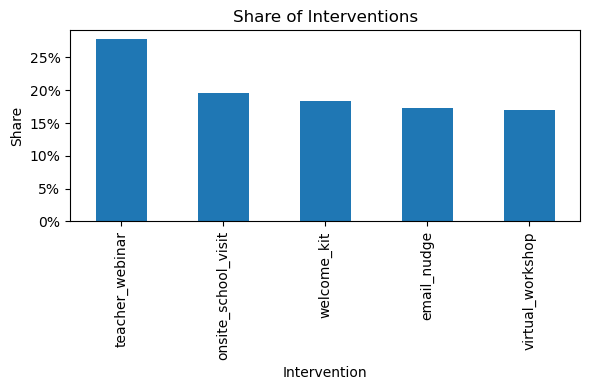

In [23]:
fig, ax = plt.subplots(figsize = (6,4))

int_shares.plot(kind="bar", ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylabel("Share")
ax.set_xlabel("Intervention")
ax.set_title("Share of Interventions")
plt.tight_layout()

A total of nearly 850 interventions occured in 2024. The distribution across intervention types is roughly equal with the exception of teacher_webinar. There are not missing values.

# Baseline Model

I will begin the analysis by estimating the average number of activations per day (λ) and the corresponding confidence interval under two simplifying assumptions:

1. Homogeneous schools – all schools have the same activation rate; students are equally likely to trigger and event regardless of their school.
2. No intervention effects – I treat the data as if the observations occured without interventions that effect activation rate.

This baseline will provide an initial understanding of the data and the scale of the problem before accounting for differences between schools nad the effects of interventions.

## ML Estimate 

In line with the above assumption, I am pooling schools in this section. That is, I model the data as if one school were observed for school-days (500 schools × 366 days), rather than as 500 separate schools observed over one year.

In [29]:
count_days = 366 # 2024 was a leap year

In [30]:
school_days = count_schools * count_days

In [31]:
mle_lambda = count_events/school_days
np.round(mle_lambda,5)

0.05767

In [32]:
events_per_year = mle_lambda * count_days
np.round(events_per_year,1)

21.1

In [33]:
event_interval = 1/mle_lambda
np.round(event_interval,1)

17.3

On average, we expect 0.06 events per day. That is, an event should roughly occur every 17 days (or 21 events per year) on average.

## Uncertainity 

To measure uncertainty, I first set a confidence level of 90%. Next, I compute Confidence Intervals (Frequentist) and Credible Intervals (Bayesian) and subsequently compare the results.

**Confidence Interval**

In [38]:
conf = 0.9
alpha = 1 - conf

In [39]:
lower_lambda_fr = 0.5 * chi2.ppf(alpha/2, 2*count_events) / school_days

In [40]:
upper_lambda_fr = 0.5 * chi2.ppf(1 - alpha/2, 2*(count_events + 1)) / school_days

In [41]:
lower_time_fr = 1/upper_lambda_fr

In [42]:
upper_time_fr = 1/lower_lambda_fr

Notice that the results are in the comparison table (below).

**Credible Interval**

The conjugate prior for the rate parameter is given by the gamma distribution. 

$ \lambda\sim Gamma(\alpha + k,\beta + E)$

where $k$ is the number of events and $E$ the number of school-days. 

In [48]:
def bayesian_int(a,b,alpha,count_events,total_days,lower_lambda_fr,upper_lambda_fr,lower_time_fr,upper_time_fr):
    gamma_shape = a + count_events
    gamma_scale = 1/(b+total_days)
    lower_lambda_ba = gamma.ppf(alpha/2, a=gamma_shape, scale=gamma_scale)
    upper_lambda_ba  = gamma.ppf(1-alpha/2, a=gamma_shape, scale=gamma_scale)
    lower_time_ba = 1/upper_lambda_ba
    upper_time_ba = 1/lower_lambda_ba
    
    df = pd.DataFrame([
        {"Approach": "Frequentist",
         "lower_lambda": lower_lambda_fr, "upper_lambda": upper_lambda_fr,
         "lower_time": lower_time_fr,     "upper_time": upper_time_fr},
        {"Approach": "Bayesian",
         "lower_lambda": lower_lambda_ba, "upper_lambda": upper_lambda_ba,
         "lower_time": lower_time_ba,     "upper_time": upper_time_ba},
    ])
    return df,lower_lambda_ba,upper_lambda_ba

I will use a flat prior where $a = 1$ and $b = 0$, but feel free to play around (e.g. Jeffreys' prior where $a = 1/2$ and $b = 0$).

In [50]:
a = 1

In [51]:
b = 0

**Comparison**

In [53]:
df_fr_ba,lower_lambda_ba,upper_lambda_ba = bayesian_int(a,b,alpha,count_events,school_days,lower_lambda_fr,upper_lambda_fr,lower_time_fr,upper_time_fr)
df_fr_ba

,Approach,lower_lambda,upper_lambda,lower_time,upper_time
0,Frequentist,0.0567,0.0586,17.0652,17.6223
1,Bayesian,0.0568,0.0586,17.0652,17.6206


First, we notice that uncertainty  is very low, the interval boundaries are very close to the point estimate in both cases. Given the fact that true data generating process indeed is Poisson and the sample size, I do not find this surprising. 

With a flat prior, the 90% credible interval is nearly identical to the 90% confidence interval. This is expected because the posterior is driven primarily by the likelihood. Using an informative prior that is consistent with the data will typically yield a narrower credible interval.

In [55]:
print(f"Frequentist interpretation: We are 90% confident that the true parameter lies in: ({np.round(lower_lambda_fr,5)},{np.round(upper_lambda_fr,5)}).")

Frequentist interpretation: We are 90% confident that the true parameter lies in: (0.05675,0.0586).


In [56]:
print(f"Bayesian interpretation: There is a 90% probability that the parameter is between: {(np.round(lower_lambda_ba,4),np.round(upper_lambda_ba,4))}.")

Bayesian interpretation: There is a 90% probability that the parameter is between: (0.0568, 0.0586).


Recall that these results describe the pooled baseline. School heterogeneity and interventions have not yet been taking into account. 

## School-specific Model

Let us relax the assumption of homogenous schools and estimate an idiosyncratic event rate

In [60]:
df_lambda_i = df_act.groupby('school_id').size().reset_index(name='event_count')
df_lambda_i['lambda_i'] = df_lambda_i['event_count'] / count_days

In [61]:
df_lambda_i.lambda_i.describe()

count   500.0000
mean      0.0577
std       0.0246
min       0.0109
25%       0.0403
50%       0.0546
75%       0.0738
max       0.1475
Name: lambda_i, dtype: float64

We see substantial variation in the rate, the 75th percentile is nearly twice as large as the 25th percentile. This is in line with the hint in the exercise that schools differ in their baseline activation rate. 

# Poisson Model (Frequentist)

The goal is to estimate the effects of interventions in order to evaluate their economic relevance/justification. To address this question, I will employ a Poisson regression model consistent with the assumptions outlined in the assignment. As a first step, I construct a panel dataset and conduct a descriptive analysis, which will later serve as the basis for the modelling section.

## Panel Dataset

**Grid (School x Day)**

We need a grid that contains each school at every day for the regression.

In [68]:
min_date = pd.to_datetime('2024-01-01', format="%Y-%m-%d")

In [69]:
max_date = pd.to_datetime('2024-12-31', format="%Y-%m-%d")

In [70]:
days = pd.date_range(min_date, max_date, freq='D', name='date')

In [71]:
dim_day = pd.DataFrame(days)

In [72]:
dim_school = df_act[['school_id']].drop_duplicates()

In [73]:
grid = pd.merge(dim_day, dim_school, how='cross')

In [74]:
df_act.duplicated(subset=['school_id', 'act_date']).sum()

371

Occasionally, a school records more than one activation event in a day, and since we are modeling counts, these instances matter. Under our assumptions, such occurrences are most likely later in the year, when intervention effects have accumulated.

In [76]:
df_events = df_act.groupby(['school_id','act_date'], as_index=False).size().rename(columns={'size':'y'}) # The event count per day is the target y

In [77]:
df_grid = grid.merge(df_events[['school_id','act_date','y']],left_on=['school_id', 'date'],right_on=['school_id', 'act_date'],how='left')

**Interventions**

We will use dummies that later on allow us to compute the cumulative counts per intervention and school_id.

In [80]:
dummies = pd.get_dummies(df_int.intervention, drop_first = False, dtype = 'int')

In [81]:
df_dummies = pd.concat([df_int, dummies], axis=1)

In [82]:
df_int[df_int.duplicated(subset=['school_id', 'int_date'],keep = False)]

,school_id,intervention,int_date
378,222,teacher_webinar,2024-08-19
379,222,virtual_workshop,2024-08-19


We do not want two rows per date-school pair. Fortunately, there are not duplicates at the  school_id-intervention-int_date level so we do not need to worry about that. 

In [84]:
df_dummies = df_dummies.groupby(['school_id','int_date'], as_index=False).max() 

In [85]:
df_dummies.drop(columns = 'intervention',inplace = True)

**Combine Grid and Interventions**

In [87]:
df = pd.merge(df_grid,df_dummies, left_on = ['school_id','date'],right_on = ['school_id','int_date'],how='left')

In [88]:
df.drop(columns = ['act_date','int_date'],inplace = True) # No longer necessary

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183000 entries, 0 to 182999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 183000 non-null  datetime64[ns]
 1   school_id            183000 non-null  int64         
 2   y                    10182 non-null   float64       
 3   email_nudge          846 non-null     float64       
 4   onsite_school_visit  846 non-null     float64       
 5   teacher_webinar      846 non-null     float64       
 6   virtual_workshop     846 non-null     float64       
 7   welcome_kit          846 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 11.2 MB


Unsurprisingly, there are many NaN given the low count of events and interventions relative to the size of the school x days grid. Because we are using a count model, it is appropriate to replace those by zero. I also convert floats to integers, the model expects integers.

In [91]:
df.fillna(0,inplace = True)

In [92]:
non_id_cols = ['y', 'email_nudge', 'onsite_school_visit','teacher_webinar', 'virtual_workshop', 'welcome_kit']

In [93]:
df[non_id_cols] = df[non_id_cols].astype(int)

In [94]:
df.sort_values(['school_id', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)

## Descriptive Analysis

Let us look at some statistics to get a better understanding of the data. 

**Interventions**

In [98]:
df.head(1)

,date,school_id,y,email_nudge,onsite_school_visit,teacher_webinar,virtual_workshop,welcome_kit
0,2024-01-01,0,0,0,0,0,0,0


In [99]:
df['any_intervention'] = df[['email_nudge', 'onsite_school_visit','teacher_webinar', 'virtual_workshop', 'welcome_kit']].max(axis=1)

In [100]:
non_id_cols.append('any_intervention')

In [101]:
int_cols = [col for col in non_id_cols if col != 'y']

In [102]:
intervention_means = df[int_cols].mean()

In [103]:
expected_gap_days = 1 / intervention_means

In [104]:
expected_count_per_school = count_days * intervention_means

In [105]:
summary_intervention = pd.DataFrame({'prob_per_day': intervention_means,'expected_gap_days': expected_gap_days,'expected_count_per_school': expected_count_per_school})

In [106]:
summary_intervention

,prob_per_day,expected_gap_days,expected_count_per_school
email_nudge,0.0008,"1,244.8980",0.2940
onsite_school_visit,0.0009,"1,102.4096",0.3320
teacher_webinar,0.0013,778.7234,0.4700
virtual_workshop,0.0008,"1,270.8333",0.2880
welcome_kit,0.0008,"1,180.6452",0.3100
any_intervention,0.0046,216.3121,1.6920


Interventions are rare, schools should not expect more than two interventions of any type in a year.

**Events**

In [109]:
event_statistics = df['y'].describe().loc[['count', 'mean', 'std', 'max']].reset_index()

In [110]:
event_statistics

,index,y
0,count,"183,000.0000"
1,mean,0.0577
2,std,0.2420
3,max,3.0000


As seen above, events (y) are fairly rare. 

In [112]:
dispersion_index = df.y.var()/df.y.mean()
print(f"Dispersion index: {np.round(dispersion_index,2)}")

Dispersion index: 1.02


Overdispersion (variance exceeds the mean), is a common issue in Poisson. Fortunately, this is not a problem in our case. 

**Interventions & Events**

It is worth understanding how interventions and events co-move.

In [116]:
monhtly_activations = df.groupby(df['date'].dt.to_period('M'))['y'].sum()

In [117]:
monhtly_interventions = df.groupby(df['date'].dt.to_period('M'))['any_intervention'].sum()

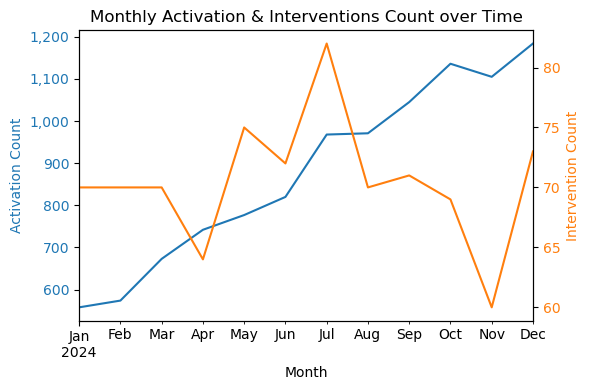

In [118]:
fig, ax1 = plt.subplots(figsize=(6, 4))


monhtly_activations.plot(ax=ax1, color='tab:blue')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_xlabel("Month")
ax1.set_ylabel("Activation Count", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
monhtly_interventions.plot(ax=ax2, color='tab:orange')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel("Intervention Count", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
ax1.set_title("Monthly Activation & Interventions Count over Time")
plt.tight_layout()

Activations trend up over the year with a notable bump in July and dip in November dip. Monthly intervention flows are roughly flat with a pronounced peak in July and drop in November. The July peak lines up with the activation jump. The November dip in activations, however, is a less expected because interventions stack up over time and their effects do not decay. Hence, even in the absence of any interventions in November, we would expect roughly same level of activations as in October. However, structural factors may play a role. The lower activity in November might be explained by ample time before the next round of certificates or the Christmas at the horizon. Of course, it could also just be random noise. 

I aggregate to monthly values to smooth the series. At this stage I do not differentiate the effectiveness across intervention types.

## Regression

Given the scope of the exercise, the assumptions, and what we have observed so far, a Fixed-Effects Poisson regression model is suitable to estimate the intervention effects. Because we only have one year of data, I cannot estimate seasonal patterns. That said, adding time fixed effects could help account for changes in activations driven by unobserved factors (e.g., holidays, growing platform popularity, or the beginning and end of the school year).

In a real modeling scenario, I would include time fixed effects in the baseline specification, as they can support identification of the intervention effects. However, given the scope of this assessment and the assumptions provided, I proceed with the simpler baseline specification.

Notice that this is a casual-inference problem and therefore, I will not train-test split data.

**Cumulative Intervention Count**

We need the cumulative count of the interventions for the model. 

In [124]:
int_cols.remove('any_intervention')

In [125]:
df.columns

Index(['date', 'school_id', 'y', 'email_nudge', 'onsite_school_visit',
       'teacher_webinar', 'virtual_workshop', 'welcome_kit',
       'any_intervention'],
      dtype='object')

In [126]:
df_reg = df[['date', 'school_id', 'y', 'email_nudge', 'onsite_school_visit','teacher_webinar', 'virtual_workshop', 'welcome_kit']].copy()

In [127]:
df_reg[int_cols] = df_reg.groupby('school_id', group_keys=False)[int_cols].cumsum()

**Model**

In [129]:
formula_base = 'y ~ ' + ' + '.join(int_cols) + ' + C(school_id)' 

In [130]:
model_base = smf.glm(formula=formula_base,data=df_reg,family=sm.families.Poisson()) # No churns as per assumption, we therefore do not need an exposure offset 

In [131]:
res_base = model_base.fit(cov_type='cluster', cov_kwds={'groups': df_reg['school_id']}) # Cluster-robust covariance estimator

# Results

The summary output is verbose because it contains the parameter estimates etc. of the FE which are not intersting. 

In [134]:
res_base.summary2().tables[0]

,0,1,2,3
0,Model:,GLM,AIC:,79717.0838
1,Link Function:,Log,BIC:,-2153217.2782
2,Dependent Variable:,y,Log-Likelihood:,-39354.
3,Date:,2025-08-25 13:55,LL-Null:,-40924.
4,No. Observations:,183000,Deviance:,58119.
5,Df Model:,504,Pearson chi2:,1.81e+05
6,Df Residuals:,182495,Scale:,1.0000
7,Method:,IRLS,,


In [135]:
# Overdispersion test:
np.round(res_base.pearson_chi2 / res_base.df_resid,2)

0.99

Given the scope of the exercise, I will not discuss the regression statistics in detail. I do not see any red flags and overdispersion does not seem to be a concern. Let us look at the interesting  parameter estimates.

In [137]:
mask = ~res_base.params.index.str.contains(r"C\(school_id\)")

In [138]:
idx = res_base.params[mask].index.intersection(res_base.conf_int().index)

In [139]:
coefs = res_base.params.loc[idx]
pvals = res_base.pvalues.loc[idx]
conf = res_base.conf_int().loc[idx]
irr     = np.exp(coefs)
irr_ci  = np.exp(conf)

In [140]:
df_baseline = pd.DataFrame({
    "coef": coefs,
    "pval": pvals,
    "ci_lower": conf[0],
    "ci_upper": conf[1],
    "IRR": irr,
    "IRR_ci_lower": irr_ci[0],
    "IRR_ci_upper": irr_ci[1],
})

In [141]:
df_baseline

,coef,pval,ci_lower,ci_upper,IRR,IRR_ci_lower,IRR_ci_upper
Intercept,-3.0289,0.0000,-3.1027,-2.9551,0.0484,0.0449,0.0521
email_nudge,-0.1378,0.0054,-0.2349,-0.0407,0.8712,0.7906,0.9601
onsite_school_visit,0.5076,0.0000,0.4278,0.5874,1.6613,1.5339,1.7993
teacher_webinar,0.7875,0.0000,0.6996,0.8753,2.1978,2.0130,2.3996
virtual_workshop,0.3868,0.0000,0.2905,0.4830,1.4722,1.3372,1.6210
welcome_kit,0.3773,0.0000,0.2826,0.4720,1.4583,1.3265,1.6031


*General Findings*

The coefficients are on a log scale and measure the change in the log of the expected count for a one-unit increase in the regressor (i.e., one additional intervention). Because this scale is hard to interpret, we focus on IRRs.

The intercept IRR corresponds to the expected daily event count for the baseline school (no interventions). It is slightly lower than the pooled MLE estimate we obtained earlier, which does not account for interventions or school heterogeneity. 

The intervention IRRs translate into the percentage changes as follows: (IRR − 1) * 100. An additional teacher webinar increases the expected count by 120%. Hence, the output table suggests that a teacher webinar has the biggest effect, even exceeding that of an onsite visit. The difference is substantial: the lower bound of the webinar is larger than the upper bound of the onsite visit. A virtual workshop and welcome kit increase the expected event count too. All intervention coefficients are statistically significant at the 95% confidence level. The email_nudge coefficient, does not have the expected positive effect. In fact, we expect a 13% (1 − 0.87) reduction in the count for every additional email. This is a contradiction to the assumption that all interventions have a positive effect. I shed light on this using a Bayesian model which allows me to effectively rule out negative intervention coefficients.

The school FEs absorb time-invariant differences across schools (e.g., total number of teachers and pupils). The intervention coefficients are identified from within-school variation over time because the interventions accumulate over time.

Given the scope of the assessment (incl. the assumptions) and the results, I will not conduct any robustness checks (e.g., Adding time-fixed effects or two-way clustered robust SE for shocks that affect schools simultaneously), try another model (e.g. Negative Binomial or Zero-Inflated Poisson), or engage in model/residual diagnostics.

## Additional Monthly Activations

**Single School**

The effect of each intervention is proportional to the school’s own baseline activation rate. This means we cannot simply use the intercept to compute the absolute change from an additional intervention; we need to consider the school-specific baseline. To illustrate, let us look at one particular school and compute its expected baseline activations in the absence of interventions.

If we include (monhtly) time fixed effects, the interpretation changes slightly: the intercept then represents the baseline for the reference school in the reference month, rather than a general overall baseline.

In [147]:
df_baseline.loc[df_baseline.index[1:], 'expected_pct_inrcease'] = (df_baseline.loc[df_baseline.index[1:], 'IRR'] - 1) * 100

In [148]:
df_baseline.loc[df_baseline.index[1:], 'expected_pct_inrcease_low'] = (df_baseline.loc[df_baseline.index[1:], 'IRR_ci_lower'] - 1) * 100

In [149]:
df_baseline.loc[df_baseline.index[1:], 'expected_pct_inrcease_up'] = (df_baseline.loc[df_baseline.index[1:], 'IRR_ci_upper'] - 1) * 100

In [150]:
baseline_monthly_1 = np.exp(res_base.params.loc["C(school_id)[T.1]"] + res_base.params["Intercept"]) *30 # Assume every month has 30 days
np.round(baseline_monthly_1 ,2) 
# Expected number of activations in the absence of interventions

1.29

In [151]:
df_school_1 = pd.DataFrame({
    "expected_abs_increase_month": baseline_monthly_1 * (df_baseline["IRR"].iloc[1:] - 1),
    "expected_abs_increase_month_low": baseline_monthly_1 * (df_baseline["IRR_ci_lower"].iloc[1:] - 1),
    "expected_abs_increase_month_up": baseline_monthly_1 * (df_baseline["IRR_ci_upper"].iloc[1:] - 1),
})
df_school_1
# The values indicate the expected absolute change per month for one additional intervention. Shown are the point estimates as well as lower and upper bound of the 95% CI. 
# Notice that this neglects uncertainty in the baseline activation. 

,expected_abs_increase_month,expected_abs_increase_month_low,expected_abs_increase_month_up
email_nudge,-0.1665,-0.2707,-0.0516
onsite_school_visit,0.8552,0.6904,1.0336
teacher_webinar,1.5490,1.3100,1.8099
virtual_workshop,0.6107,0.4360,0.8030
welcome_kit,0.5926,0.4223,0.7799


**Intervention Summary Table:**

To get a broader picture, I will also provide the mean of the above across all schools based on their individual baseline activation.

In [154]:
interventions = df_school_1.index.tolist()

In [155]:
intercept = float(res_base.params["Intercept"])
school_baseline = np.concatenate([[0.0], res_base.params.filter(like="C(school_id)").to_numpy()]) # We need the zero because the length of the array needs to be identical to the number of FE plus the baseline
mean_baseline_monthly = 30.0 * np.exp(intercept) * np.mean(np.exp(school_baseline))

In [156]:
avg_uplift = pd.DataFrame({
    "mean_expected_abs_increase_month":mean_baseline_monthly * (df_baseline.loc[interventions, "IRR"] - 1.0),
    "mean_expected_abs_increase_month_low":mean_baseline_monthly * (df_baseline.loc[interventions, "IRR_ci_lower"] - 1.0),
    "mean_expected_abs_increase_month_up":mean_baseline_monthly * (df_baseline.loc[interventions, "IRR_ci_upper"] - 1.0),
})

In [157]:
summary_pct_lift = df_baseline.drop(index="Intercept")[["expected_pct_inrcease", "expected_pct_inrcease_low", "expected_pct_inrcease_up"]].merge(
    avg_uplift, left_index=True, right_index=True
)

In [158]:
summary_pct_lift = summary_pct_lift.rename(columns={
    "expected_pct_inrcease": "% Change",
    "expected_pct_inrcease_low": "% Change (low)",
    "expected_pct_inrcease_up": "% Change (up)",
    "mean_expected_abs_increase_month": "Monthly Lift",
    "mean_expected_abs_increase_month_low": "Lift (low)",
    "mean_expected_abs_increase_month_up": "Lift (up)"
})

In [159]:
np.round(mean_baseline_monthly,2)

1.08

The average monthly activation rate per school, in the absence of interventions, is about 1.1 activations. The table below presents the estimated percentage change (with 95% confidence intervals) from one additional intervention, along with the corresponding average monthly uplift and its 95% confidence interval.

In [161]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(summary_pct_lift)

,% Change,% Change (low),% Change (up),Monthly Lift,Lift (low),Lift (up)
email_nudge,-12.88,-20.94,-3.99,-0.14,-0.23,-0.04
onsite_school_visit,66.13,53.39,79.93,0.72,0.58,0.87
teacher_webinar,119.78,101.30,139.96,1.30,1.10,1.51
virtual_workshop,47.22,33.72,62.10,0.51,0.36,0.67
welcome_kit,45.83,32.65,60.31,0.50,0.35,0.65


## Efficiency of Onsite Visits vs Virtual Workshops

In [163]:
df_baseline

,coef,pval,ci_lower,ci_upper,IRR,IRR_ci_lower,IRR_ci_upper,expected_pct_inrcease,expected_pct_inrcease_low,expected_pct_inrcease_up
Intercept,-3.0289,0.0000,-3.1027,-2.9551,0.0484,0.0449,0.0521,NaN,NaN,NaN
email_nudge,-0.1378,0.0054,-0.2349,-0.0407,0.8712,0.7906,0.9601,-12.8751,-20.9354,-3.9931
onsite_school_visit,0.5076,0.0000,0.4278,0.5874,1.6613,1.5339,1.7993,66.1311,53.3890,79.9317
teacher_webinar,0.7875,0.0000,0.6996,0.8753,2.1978,2.0130,2.3996,119.7836,101.3046,139.9590
virtual_workshop,0.3868,0.0000,0.2905,0.4830,1.4722,1.3372,1.6210,47.2250,33.7153,62.0995
welcome_kit,0.3773,0.0000,0.2826,0.4720,1.4583,1.3265,1.6031,45.8284,32.6530,60.3124


In [164]:
onsite_IRR = df_baseline.loc['onsite_school_visit','IRR']
virtual_IRR = df_baseline.loc['virtual_workshop','IRR']
np.round(onsite_IRR/virtual_IRR,2)
# Ratio of the coefficients

1.13

First, we see that the confidence intervals for both relevant interventions overlap, $onsite\_{ci}\_{lower} < virtual\_{ci}\_{upper}$. Second, the IRR ratio of both is close to 1 (rather than 2). This casts some doubts on the idea that onsite visits are twice as effective as virtual interventions. Let us formally test

The costs are justified if onsite is at least twice as effective as virtual. Hence, we want to reject the hypothesis that the opposite is true ("innocent unless proven guilty"), i.e. visits are at not twice as efficient as virtual contact. The Null becomes:

$H_0 = coeff\_{onsite} - coeff\_{virtual} \le log(2)$

In [166]:
m = np.log(2)

In [167]:
t_test = res_base.t_test(f"onsite_school_visit - virtual_workshop = {m}", use_t = False) # z or t test does not make a huge difference here

In [168]:
t_test

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1208      0.064     -8.950      0.000      -0.005       0.246

The above table indicates that we reject the hypothesis that the difference between both coefficients equals log(2). Notice that this is not our Null.

In [170]:
z_score = t_test.tvalue

In [171]:
p_value = 1 - stats.norm.cdf(z_score)
prob = stats.norm.cdf(z_score)

In [172]:
print(f"One-sided p-value): {p_value.item():.2f}")
print(f"P(delta ≥ log(2)) : {prob.item():.2f}")

One-sided p-value): 1.00
P(delta ≥ log(2)) : 0.00


The z-score is negative, yielding a one-sided p-value ≈ 1.00, so we cannot reject the Null. Under the normal approximation, the probability that onsite is at least twice as effective as virtual is ≈ 0%. Given the cost difference, onsite visits are not justified at a 2× threshold.

# Bayesian Model

One of the advantages of a Bayesian approach is that it allows us to incorporate prior knowledge. Hence, we can force the coefficients to be positive and thus address a shortcoming of the above frequentist-model. Furthermore, this approach allows probabilistic statements about the estimated parameters. 

To reduce the computation cost, I only sample for subset of schools. 

## Sampeling

In [177]:
schools = df_reg.school_id.unique().tolist()
random.seed(42)
sample = random.sample(schools,500) # Change for faster runs

In [178]:
df_bayes = df_reg.query('school_id in @sample')

In [179]:
features = ["email_nudge", "onsite_school_visit", "teacher_webinar", 
            "virtual_workshop", "welcome_kit"]
X = df_bayes[features].to_numpy(dtype=float)

In [180]:
y = df_bayes["y"].astype("int32").to_numpy()

In [181]:
school_idx, schools = pd.factorize(df_bayes["school_id"], sort=True)
S = len(schools)

In [ ]:
with pm.Model() as m:
    
    random_effects = True
    force_pos_email = True
    # RE Idea: Each school's intercept is modeled as a deviation from the overall intercept, all deviations are constrained to sum to zero. Hence, this makes the intercept the mean across schools and 
    # no longer refers to a baseline school. 
    
    # Intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=5.0)

    # Intervention Priors
    if force_pos_email:
        beta_email_nudge         = pm.HalfNormal("beta_email_nudge", sigma=1.0)
    else:
        beta_email_nudge         = pm.Normal("beta_email_nudge", mu=0.0, sigma=1)
    beta_onsite_school_visit = pm.HalfNormal("beta_onsite_school_visit", sigma=1.0)
    beta_teacher_webinar     = pm.HalfNormal("beta_teacher_webinar", sigma=1.0)
    beta_virtual_workshop    = pm.HalfNormal("beta_virtual_workshop", sigma=1.0)
    beta_welcome_kit         = pm.HalfNormal("beta_welcome_kit", sigma=1.0)

    betas = pm.math.stack([beta_email_nudge,beta_onsite_school_visit,beta_teacher_webinar,beta_virtual_workshop,beta_welcome_kit])
    
    if random_effects:
        alpha_raw = pm.Normal("alpha_raw", 0, 1, shape=S) # Random intercepts for each school before scaling
        sigma_alpha = pm.HalfNormal("sigma_alpha", 1.0) # Variation across schools 
        alpha = pm.Deterministic("alpha", sigma_alpha * (alpha_raw - pm.math.mean(alpha_raw))) # Ensure that the coefficients sum up to zero
        eta = intercept + pm.math.dot(X, betas) + alpha[school_idx]
    else:
        eta = intercept + pm.math.dot(X, betas)
           
    mu = pm.math.exp(eta)
    y_obs = pm.Poisson("y_obs", mu=mu, observed=y)

    idata = pm.sample(draws=1000, tune=500, chains=4, target_accept=0.9)

Sampling results are already available:

In [183]:
idata_half = az.from_netcdf("bayes_half_normal.nc")

## Diagnostics

Let us briefly check if the Bayesian model is reliable:

In [186]:
coeffs = ["beta_email_nudge", "beta_onsite_school_visit", "beta_teacher_webinar","beta_virtual_workshop","beta_welcome_kit","intercept"]

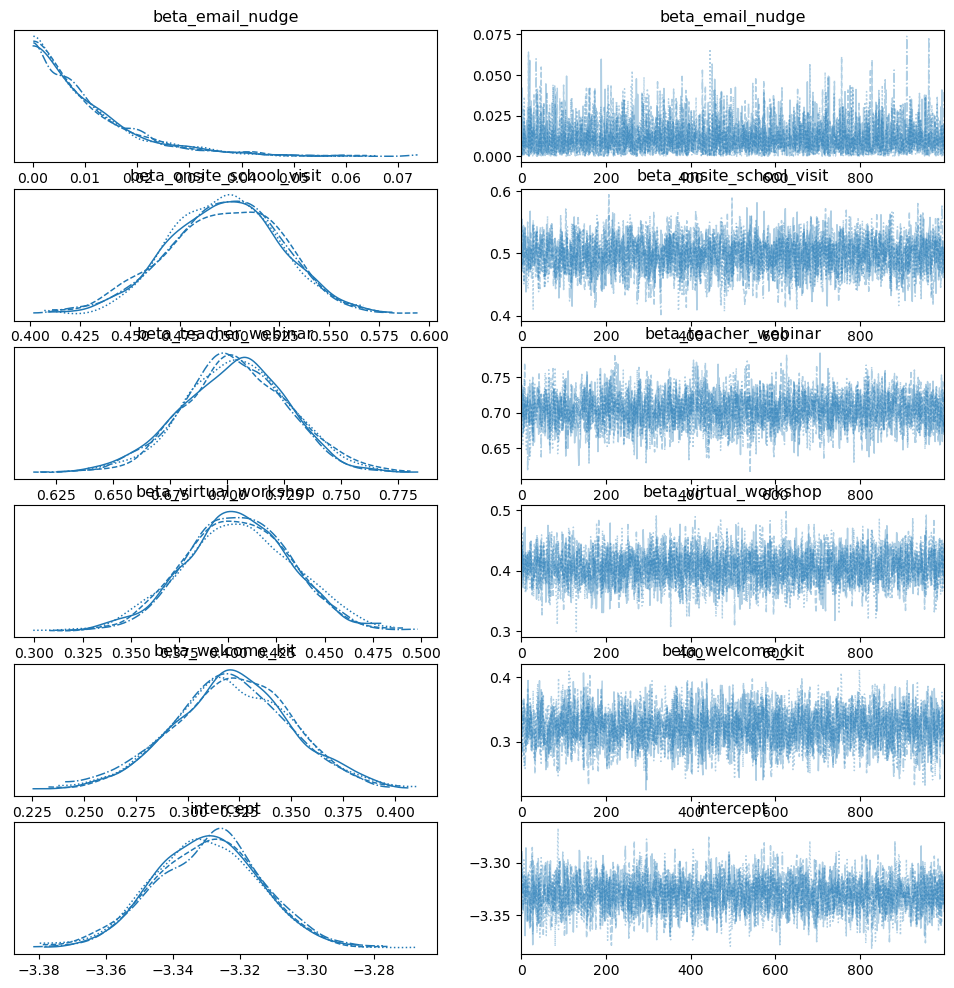

In [187]:
az.plot_trace(idata_half, var_names=coeffs);

The densities (left side) appear comparable and thus, the traces have converged to a similar posterior distribution, the distributions have a single mode. Furthermore, that trace plots (right side) look stationary with no drift, this is consistent with convergence.  It is encouraging to see (below) that the marginal energy distribution and the energy distribution largely overlap because that the algorithm appropriately explored the posterior. Hence, it is unlikely that our estimates are biased because parts of the posterior have only infrequently been visited.  This should be good enough, and we proceed with the results.

<Axes: >

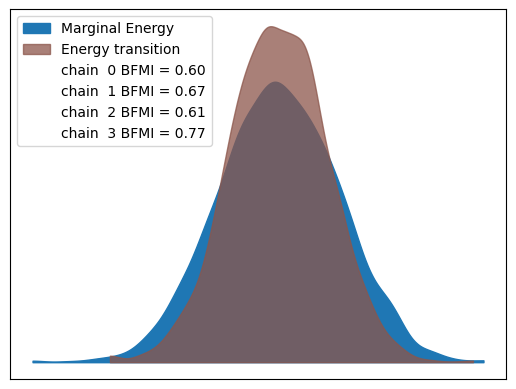

In [189]:
az.plot_energy(idata_half)

## Result Comparsion (Frequentist vs Bayesian)

**HalfNormal Priors**

In [192]:
results_bayes = az.summary(idata_half,hdi_prob=0.95).tail(8).copy()

In [193]:
results_bayes[['mean', 'hdi_2.5%', 'hdi_97.5%']].loc['beta_email_nudge']

mean        0.0110
hdi_2.5%    0.0000
hdi_97.5%   0.0310
Name: beta_email_nudge, dtype: float64

Let us focus on the email_nudge coefficient at this stage. Contrary to the Frequentist model, the posterior mean of the email_nudge coefficient is not negative, consistent with the assumptions. However, the lower credibility bound is zero.

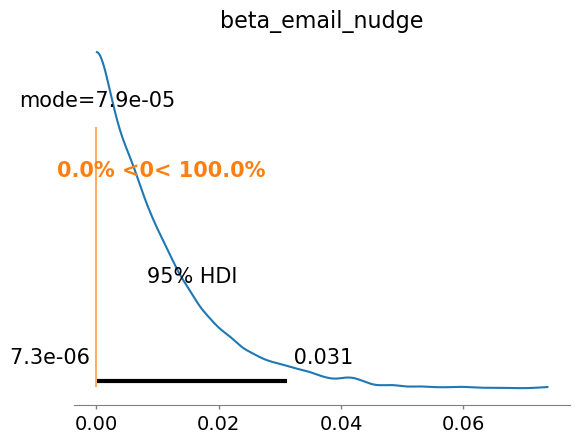

In [195]:
az.plot_posterior(
    idata_half,
    var_names=["beta_email_nudge"],
    hdi_prob=0.95,
    point_estimate="mode",   
    ref_val=0.0              
)
plt.show()

The mode of the email_nudge coefficient is close to zero. This is consitent with a HalfNormal prior (mode at 0) together with weak/negative signal in the data and the non-negativity constraint. I therefore sample again with a weaker prior for the email_nudge coefficient. 

**Comparison (Normal Prior)**

Let us take a look at the the resulting posterior parameter distribution and compare it to the previous results (frequentist model). 

In [199]:
idata_full = az.from_netcdf("bayes_normal.nc")

In [200]:
results_bayes_normal = az.summary(idata_full,hdi_prob=0.95).tail(8).copy()

In [201]:
results_bayes_normal.index = results_bayes.index.str.replace(r"^beta_", "", regex=True)
results_bayes_normal.rename(index={'intercept': 'Intercept'},inplace = True)

In [202]:
df_compare = pd.merge(df_baseline[['coef','ci_lower','ci_upper']], results_bayes_normal[['mean','hdi_2.5%','hdi_97.5%']], left_index=True,right_index=True)

In [203]:
df_compare.rename(columns = {'coef':'freq_coef','mean':'bayes_coeff'},inplace = True)

In [204]:
overlap_lower = df_compare[["ci_lower", "hdi_2.5%"]].max(axis=1)
overlap_upper = df_compare[["ci_upper", "hdi_97.5%"]].min(axis=1)
df_compare["overlap_lower"] = overlap_lower
df_compare["overlap_upper"] = overlap_upper
df_compare["has_overlap"] = overlap_upper > overlap_lower
df_compare["overlap_width"] = (overlap_upper - overlap_lower).clip(lower=0)

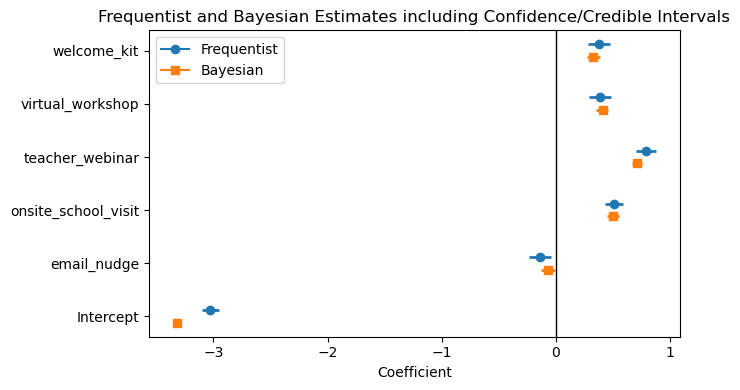

In [205]:
fig, ax = plt.subplots(figsize=(7, 4))


y_pos = list(range(len(df_compare)))[::-1]
for i, term in enumerate(df_compare.index[::-1]):
    y = y_pos[i]
    # Frequentist
    ax.hlines(y + 0.12, df_compare.loc[term, "ci_lower"], df_compare.loc[term, "ci_upper"],
              linewidth=2, color="C0")
    ax.plot(df_compare.loc[term, "freq_coef"], y + 0.12, marker="o", markersize=6, color="C0")

    # Bayesian
    ax.hlines(y - 0.12, df_compare.loc[term, "hdi_2.5%"], df_compare.loc[term, "hdi_97.5%"],
              linewidth=2, color="C1")
    ax.plot(df_compare.loc[term, "bayes_coeff"], y - 0.12, marker="s", markersize=6, color="C1")    


ax.axvline(0, linewidth=1, color="black")

ax.set_yticks(y_pos)
ax.set_yticklabels(df_compare.index[::-1])

ax.set_xlabel("Coefficient")
ax.set_title("Frequentist and Bayesian Estimates including Confidence/Credible Intervals")

handles = [
    plt.Line2D([0], [0], color="C0", marker="o", linestyle="-", label="Frequentist"),
    plt.Line2D([0], [0], color="C1", marker="s", linestyle="-", label="Bayesian")
]
ax.legend(handles=handles)


plt.tight_layout()

We observe that intervention coefficients from the Frequentist and Bayesian model are comparable in terms of both the point estimate and the respective intervals. All coefficients are statistically significant. In contradiction to the assumption of positive intervention effects, the email_nudge coefficient is negative (but small). Given this result, I conclude that there is no evidence for a positive intervention effect of an email. 

Additionally, the intercept coefficients slightly differ. Recall that the intercept in the baseline model reflects the baseline school's activation rate. In the Bayesian model, however, it corresponds to the average rate across schools. Furthermore,  the focus is on the effects of the interventions and the difference is small and therefore, I will not explore this further. 

In [207]:
df_compare

,freq_coef,ci_lower,ci_upper,bayes_coeff,hdi_2.5%,hdi_97.5%,overlap_lower,overlap_upper,has_overlap,overlap_width
Intercept,-3.0289,-3.1027,-2.9551,-3.3220,-3.3530,-3.2890,-3.1027,-3.2890,False,0.0000
email_nudge,-0.1378,-0.2349,-0.0407,-0.0710,-0.1310,-0.0070,-0.1310,-0.0407,True,0.0903
onsite_school_visit,0.5076,0.4278,0.5874,0.5020,0.4490,0.5540,0.4490,0.5540,True,0.1050
teacher_webinar,0.7875,0.6996,0.8753,0.7100,0.6630,0.7570,0.6996,0.7570,True,0.0574
virtual_workshop,0.3868,0.2905,0.4830,0.4080,0.3530,0.4600,0.3530,0.4600,True,0.1070
welcome_kit,0.3773,0.2826,0.4720,0.3280,0.2740,0.3830,0.2826,0.3830,True,0.1004
